# 3. Field of 8 inclined boreholes with straight trajectories : (b) Convergence of geothermax with regards to the discretization
The convergence of the model is evaluated by comparison with a solution obtained with a fine discretization.

In [1]:
# Import necessary packages
# Import packages for geothermax
import geothermax as gm
from jax import numpy as jnp

# Import packages for visualization
from matplotlib import pyplot as plt
import pandas as pd

### 3(b).1. Simulation parameters

In [2]:
# Borehole dimensions
D = 2.0             # Borehole buried depth (m)
L = 150.0           # Borehole length (m)
r_b = 0.075         # Borehole radius (m)
# Borehole spacings (m), tilt (deg), and inclinations (deg)
B = L * 0.025
tilt = jnp.radians(20.)
orientation = jnp.radians(jnp.array([180., 135., -135., 90., -90., 45., -45, 0.]))

# Ground properties
alpha = 1.0e-6      # Ground thermal diffusivity (m2/s)
k_s = 2.0           # Ground thermal conductivity (W/m.K)

# Delta-circuit thermal resistances (m.K/W)
R_d = jnp.array(
    [
        [0.28669298, -3.18697907],
        [-3.18697907, 0.28669298]
    ]
)

# Fluid properties
m_flow_borehole = 0.375 # Total fluid mass flow rate per borehole (kg/s)
m_flow_network = m_flow_borehole * len(orientation)
# The fluid is propylene-glycol (20 %) at 20 degC
cp_f = 3976.8       # Fluid specific isobaric heat capacity (J/kg.K)

The convergence of the solution is evaluated near steady-state, at $\ln(t/t_s)=5$.

In [3]:
ts = L**2 / (9 * alpha)    # Bore field characteristic time
lntts = jnp.array([5.])
time = jnp.exp(lntts) * ts

## 3(b).2. Reference solution
The reference solution is evaluated using $S=20$ segments of $N=11$ nodes (220 nodes in total).

In [4]:
N_ref = 11
S_ref = 20

basis = gm.Basis.Legendre(N_ref)
boreholes = []
for i, _orientation in enumerate(orientation):
    boreholes.append(
        gm.SingleUTube.from_dimensions(
            R_d, L, D, r_b, i * B, 0., basis, S_ref, tilt=tilt, orientation=_orientation))
borefield_reference = gm.Network(boreholes)

The `gFunction` object is initialized and the $g$-function is evaluated.

In [5]:
gfunc_reference = gm.gFunction(borefield_reference, m_flow_network, cp_f, time, alpha, k_s)
gfunc_reference.simulate()

## 3(b).3. Convergence of geothermax
The solution is evaluated for numbers of segments ranging from $1$ to $5$ and for numbers of nodes per segment ranging from $1$ to $11$.

The `Borefield` objects are first initialized for each discretization.

In [6]:
N_max = 11
S_max = 5
n = 0

borefields = []
for _S in range(1, S_max + 1):
    for _N in range(1, N_max + 1):
        basis = gm.Basis.Legendre(_N)
        boreholes = []
        for i, _orientation in enumerate(orientation):
            boreholes.append(
                gm.SingleUTube.from_dimensions(
                    R_d, L, D, r_b, i * B, 0., basis, _S, tilt=tilt, orientation=_orientation))
        borefields.append(gm.Network(boreholes))

The $g$-functions are then evaluated.

In [7]:
gfunc = [gm.gFunction(borefield, m_flow_network, cp_f, time, alpha, k_s) for borefield in borefields]
for _gfunc in gfunc:
    _gfunc.simulate()
values = jnp.array([_gfunc.g[-1] for _gfunc in gfunc]).reshape(S_max, N_max).T

In [8]:
# Format and print dataframe
df = pd.DataFrame(
    values,
    columns=[f'S = {_S}' for _S in jnp.arange(1, S_max + 1)],
    index=jnp.arange(1, N_max + 1))
df.index.name = 'N'
df.style.set_caption(r'$g$-Function at $ln(t/t_s)=5$') 

,S = 1,S = 2,S = 3,S = 4,S = 5
N,,,,,
1,12.869995,12.297012,12.079844,11.957026,11.875278
2,12.084946,11.808661,11.708858,11.656545,11.623454
3,11.811336,11.657578,11.603538,11.574364,11.557332
4,11.688249,11.591569,11.557902,11.542315,11.534686
5,11.622020,11.558995,11.538419,11.530116,11.526029
6,11.584899,11.541692,11.528880,11.523852,11.521108
7,11.562266,11.532388,11.523636,11.520129,11.517924
8,11.548533,11.526521,11.520263,11.517550,11.515510
9,11.539735,11.522603,11.517823,11.515468,11.513637


The relative error is calculated from the difference between the oslution and the reference:
$$
\varepsilon_{rel} = \frac{g - g_{ref}}{g_{ref}}
$$

In [9]:
error = (jnp.array([_gfunc.g[-1] for _gfunc in gfunc]).reshape(S_max, N_max).T - gfunc_reference.g[-1]) / gfunc_reference.g[-1]

In [10]:
# Format and print dataframe
df = pd.DataFrame(
    error,
    columns=[f'S = {_S}' for _S in jnp.arange(1, S_max + 1)],
    index=jnp.arange(1, N_max + 1))
df.index.name = 'N'
df.style.set_caption(r'Relative error on the $g$-function at $ln(t/t_s)=5$') 

,S = 1,S = 2,S = 3,S = 4,S = 5
N,,,,,
1,0.118443,0.068649,0.049776,0.039103,0.031999
2,0.050220,0.026210,0.017537,0.012990,0.010115
3,0.026442,0.013080,0.008384,0.005849,0.004368
4,0.015746,0.007344,0.004418,0.003063,0.002400
5,0.009990,0.004513,0.002725,0.002003,0.001648
6,0.006764,0.003009,0.001896,0.001459,0.001220
7,0.004797,0.002201,0.001440,0.001135,0.000944
8,0.003604,0.001691,0.001147,0.000911,0.000734
9,0.002839,0.001350,0.000935,0.000730,0.000571


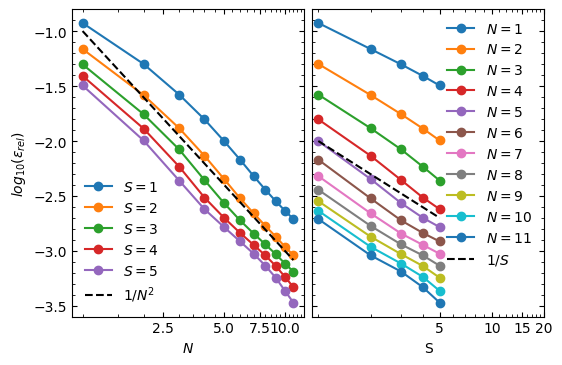

In [11]:
# Plot error as function of N and S
fig, axs = plt.subplots(ncols=2, sharey=True, layout='constrained')

N = jnp.arange(1, N_max + 1)
S = jnp.arange(1, S_max + 1)

axs[0].set_xscale('function', functions=(lambda x: jnp.log(x), lambda x: jnp.exp(x)))
axs[0] = gm.utilities._format_axis(axs[0], axis_labels=[r'$N$', r'$log_{10}(\varepsilon_{rel})$'])
axs[0].plot(N, jnp.log10(error), '-o');
axs[0].plot(N, jnp.log10(0.1 / N**2), 'k--');
axs[0].legend([f'$S={_S}$' for _S in S] + [r'$1 / N^2$'], frameon=False)

axs[1].set_xscale('function', functions=(lambda x: jnp.log(x), lambda x: jnp.exp(x)))
axs[1] = gm.utilities._format_axis(axs[1])
axs[1].set_xlabel(r'S')
axs[1].plot(S, jnp.log10(error.T), '-o');
axs[1].plot(S, jnp.log10(0.01 / S), 'k--');
axs[1].set_xlim(None, 20)
axs[1].legend([f'$N={_N}$' for _N in N] + [r'$1 / S$'], frameon=False)

fig.set_size_inches(140. / 25.4, 90. / 25.4)
fig.savefig('convergence-Eskilson-optimal.eps')